In [2]:
from Fourier_Neural_Operator import Fourier_Neural_Operator as FNO
from Fourier_Neural_Operator import SpectralConv2d_fast, SimpleBlock2d, Net2d 
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
%%time
# D_new.npy model_mod.pt


solver = FNO('Data_dt1.npy', 'model_ts1.pt', width = 10)
solver.process_data()
prediction1, y1, x1 = solver.predict(2)
loss = []
for i in range(0, 10):
    loss_temp = solver.show_error(10, 0, i)
    print(loss_temp)
    loss.append(loss_temp)

In [10]:
# Plot function tests

# Simple ImageGrid plot for all 10 timesteps

def plot_images(data1):
    fig = plt.figure(figsize=(40., 40.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(1, 10),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for i, ax in zip(range(0, 10),grid):
        # Iterating over the grid returns the Axes. #shape of arr is (nx, ny, time, channel)
        ax.imshow(np.array(data1.detach())[1,:,:,0,i])
        ax.set_title("Timestep: '{0}'".format(i))
        
# Plot function to compare prediction and ground truth

def plot_image_compare(pred, truth):
    fig = plt.figure(figsize=(40., 40.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                    axes_pad=1,  # pad between axes in inch.
                    )
    im1 = np.array(truth.detach())[1,:,:,1,0]
    im2 = np.array(truth.detach())[1,:,:,1,5]
    im3 = np.array(truth.detach())[1,:,:,1,9]
    im4 = np.array(pred.detach())[1,:,:,1,0]
    im5 = np.array(pred.detach())[1,:,:,1,5]
    im6 = np.array(pred.detach())[1,:,:,1,9]
    for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6]):
        ax.imshow(im)
        ax.set_title("")
        
## Plot function to compare prediction and ground truth

# Function to add all channels in a single image
def stack_channels(images):
    c_a = np.array(images.detach())[:,:,:,0,:]
    c_b = np.array(images.detach())[:,:,:,1,:]
    c_c = 1 - c_a - c_b
    image = np.stack((c_a, c_b, c_c), axis = 3)
    return image

def plot_image_compare_sp(pred, truth, fname = 'None'):
    f, axes = plt.subplots(2, 3, figsize=(10,8))
    
    pred_im = stack_channels(pred)
    truth_im = stack_channels(truth)
    
    pred = pred_im[1,:,:,:,:]
    truth = truth_im[1,:,:,:,:]
    
    print(pred.shape, truth.shape)
    
    f.subplots_adjust(hspace = 0.5)
    
    for ax, i in zip(axes[0,:], range(1, len(truth[0,0,0,:]), 4)):
        ax.imshow(pred[:,:,:,i])
        # i += 4
        ax.set_title('Ground Truth - Timestep {}'.format(i))
    for ax, i in zip(axes[1,:], range(1, len(pred[0,0,0,:]), 4)):
        ax.imshow(truth[:,:,:,i])
        # i += 4
        ax.set_title('Prediction - Timestep {}'.format(i))
        
    plt.tight_layout()
    plt.savefig(fname)
    
    

In [ ]:
# Prediction for dt 5

plot_image_compare_sp(prediction1, y1, fname='Dt = 1.png')

In [ ]:
plot_images(prediction1)

In [ ]:
prediction1.shape

In [ ]:
c_a = np.array(prediction1.detach())[:,:,:,0,:]
c_b = np.array(prediction1.detach())[:,:,:,1,:]
c_c = 1 - c_a - c_b
image = np.stack((c_a, c_b, c_c), axis = 3)

In [ ]:
    fig = plt.figure(figsize=(40., 40.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(1, 10),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for i, ax in zip(range(0, 10),grid):
        # Iterating over the grid returns the Axes. #shape of arr is (nx, ny, time, channel)
        ax.imshow(image[1,:,:,:,i])
        ax.set_title("Timestep: '{0}'".format(i))

In [ ]:
# Ground truth for dt 5

plot_images(y1)

In [ ]:
plot_images(x1)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.array(loss))
plt.xticks(np.arange(0, 10, 1))
plt.savefig('LossCurve_dt5.jpg')

In [ ]:
plot_images(x1)

In [3]:
import torch

checkpoint = torch.load('model_ts5.pt', map_location=torch.device('cpu'))
model = Net2d(12, 10)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [4]:
D = np.load('Data_dt5_256(0,64).npy')

In [5]:
D.shape

(2, 256, 256, 2, 40)

In [6]:
import torch

sub = 1
S = 256
T_in = 10
T = 10
step = 1

ntest = 2

batch_size = 20

test_a = torch.tensor(D[-ntest:,::sub,::sub,::sub,:T_in])
test_u = torch.tensor(D[-ntest:,::sub,::sub,::sub,T_in:T+T_in])

gridx = torch.tensor(np.linspace(0, 64, S), dtype=torch.float)
gridx = gridx.reshape(1, S, 1, 1).repeat([1, 1, S, 1])
gridx = gridx.reshape(1, S, S, 1, 1).repeat([1, 1, 1, 2, 1])
gridy = torch.tensor(np.linspace(0, 64, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1).repeat([1, S, 1, 1])
gridy = gridy.reshape(1, S, S, 1, 1).repeat([1, 1, 1, 2, 1])

test_a = torch.cat((test_a, gridx.repeat([ntest,1,1,1,1]), gridy.repeat([ntest,1,1,1,1])), dim=-1)

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

In [ ]:
test_a.shape

In [7]:
%%time

xx = []
yy = []
yh = []
for x, y in test_loader:
    xx.append(x)
    yy.append(y)

x = xx[0]

for t in range(0, T+10, step):


    im = model(x.float())

    if t ==0:
        pred = im
    else:
        pred = torch.cat((pred, im), -1)
        # pred = im

    x = torch.cat((x[..., step:-2], im, gridx.repeat([ntest, 1, 1, 1, 1]), gridy.repeat([ntest, 1, 1, 1, 1])), dim=-1)


Wall time: 12 s


In [8]:
yy[0].shape

torch.Size([2, 256, 256, 2, 10])

(256, 256, 3, 20) (256, 256, 3, 10)


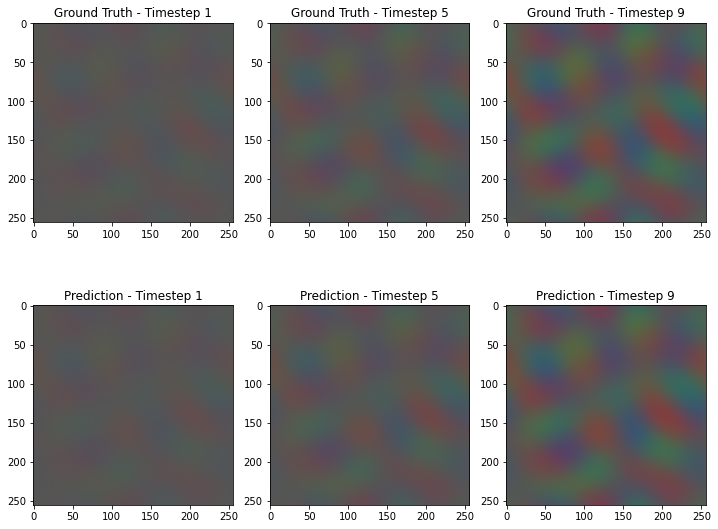

In [11]:
plot_image_compare_sp(pred, yy[0], fname = '256.png')

In [ ]:
plot_images(pred)

In [ ]:
plot_images(xx[0])

In [ ]:
from torch import nn

loss = []
for i in range(0,10):
    loss.append(nn.MSELoss(size_average = True, reduce = True, reduction = 'mean')(pred[1,:,:,1,i], yy[0][1,:,:,1,i]))
    
plt.plot(np.array(loss))
plt.xticks(np.arange(0, 10, 1))
plt.savefig('LossCurve_dt5.jpg')

In [ ]:
loss

In [ ]:
checkpoint = torch.load('model_ts5_new_mse.pt', map_location=torch.device('cpu'))

In [ ]:
loss = checkpoint['loss']

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss/800/10)

In [ ]:
loss[282]/800/10